In [720]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'BeH2_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

BeH2_STO-3G_SINGLET
Molecule geometry:
Be	0.0	0.0	0.0
H	0.0	0.0	1.29055
H	0.0	0.0	-1.29055

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -15.561352807666323
MP2 energy:  -15.583725038009472
CCSD energy: -15.594378365854427
FCI energy:  -15.594746145660254


Number of qubits: 14


In [721]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 14 -> 9 qubits

The following stabilizers were identified:

-1 ZIZIIZIZIZZIIZ 
-1 IZIZIZIZIZIZIZ 
 1 IIIIZZIIIIIIZZ 
 1 IIIIIIZZIIIIII 
 1 IIIIIIIIZZIIII


In [722]:
n_qubits = 6
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIIZZ', 'IIIZII', 'IIIZIZ', 'IIIZZI', 'IIIZZZ', 'IIZIII', 'IIZIIZ', 'IIZIZI', 'IIZZII', 'IIZZZZ', 'IZIIII', 'IZIIIZ', 'IZIIZI', 'IZIZII', 'IZIZZZ', 'IZZIII', 'IZZZIZ', 'IZZZZI', 'ZIIIII', 'ZIIIIZ', 'ZIIIZI', 'ZIIIZZ', 'ZIIZII', 'ZIIZZZ', 'ZIZIII', 'ZIZIZZ', 'ZIZZIZ', 'ZIZZZI', 'ZZIIII', 'ZZIIZZ', 'ZZIZIZ', 'ZZIZZI', 'ZZZIIZ', 'ZZZIZI', 'ZZZZII', 'ZZZZIZ', 'ZZZZZI', 'ZZZZZZ', 'IIIZZX', 'IZZZZX', 'ZIIIZX', 'ZZZIZX', 'IIIZXZ', 'IZZZXZ', 'ZIIIXZ', 'ZIIZXI', 'ZZZIXZ', 'ZZZZXI', 'IIIIYY', 'ZZZZYY', 'IIIXZZ', 'ZZZXZI', 'ZIIXZX', 'ZIIYZY', 'ZZZXZX', 'ZZZYZY', 'IIIYYI', 'IZZYYI', 'ZIIYYZ', 'ZZZYYZ', 'IIIXYY', 'IIIYYX', 'IIXIII', 'IIXIZZ', 'ZZXZIZ', 'ZZXZZI', 'IIXIXX', 'IIXIYY', 'IIYIXY', 'IIYIYX', 'IIXXII', 'IIXXZZ', 'IIYYII', 'IIYYZZ', 'IXIIII', 'IXIIZZ', 'ZXZZIZ', 'ZXZZZI', 'IXIIXX', 'IXIIYY', 'IYIIXY', 'IYIIYX', 'IXIXII', 'IXIXZZ', 'IYIYII', 'IYIYZZ', 'IXXIII', 'IYYIII', 'XIIIZZ', 'XZZZZI', 'XIIZZX', 'XZZZZX', 'YIIZZY', 'YZZZZY', 'YII

In [729]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]

ucc_trunc = ucc_cs.sort()[:40]
anz_cs = AnsatzOp(ucc_trunc.symp_matrix, ucc_trunc.coeff_vec)

obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
vqe_result = obs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs
)

opt_params = vqe_result[0]['x']
vqe_result[0]['fun'] - molecule.fci_energy

0.006142660319323312

In [730]:
from qiskit import QuantumCircuit
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz = ansatz.compose(anz_cs.to_QuantumCircuit(bind_params=False))
ansatz.draw()

░                                                 ░             »
q_0: ──────░────■────────────────────────────────────────■───░─────────────»
           ░  ┌─┴─┐                                    ┌─┴─┐ ░             »
q_1: ──────░──┤ X ├───■─────────────────────────────■──┤ X ├─░─────────────»
           ░  ├───┤ ┌─┴─┐                         ┌─┴─┐├───┤ ░  ┌───┐      »
q_2: ──────░──┤ H ├─┤ X ├──■───────────────────■──┤ X ├┤ H ├─░──┤ H ├──────»
           ░  └───┘ └───┘  │                   │  └───┘└───┘ ░  └───┘      »
q_3: ──────░───────────────┼───────────────────┼─────────────░─────────────»
           ░               │                   │             ░             »
q_4: ──────░───────────────┼───────────────────┼─────────────░─────────────»
     ┌───┐ ░ ┌─────┐┌───┐┌─┴─┐┌─────────────┐┌─┴─┐┌───┐┌───┐ ░ ┌─────┐┌───┐»
q_5: ┤ X ├─░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[0]) ├┤ X ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├»
     └───┘ ░ └─────┘└───┘└───┘└─────────────┘└───┘└───┘└───┘ ░ └─────┘└───┘»
«                                         ░                       »
«q_0: ────────────────────────────────────░────■──────────────────»
«                                         ░  ┌─┴─┐                »
«q_1: ────────────────────────────────────░──┤ X ├────────■───────»
«                              ┌───┐      ░ ┌┴───┴┐┌───┐┌─┴─┐     »
«q_2: ──■───────────────────■──┤ H ├──────░─┤ Sdg ├┤ H ├┤ X ├──■──»
«       │                   │  └───┘      ░ └─────┘└───┘└───┘  │  »
«q_3: ──┼───────────────────┼─────────────░────────────────────┼──»
«       │                   │             ░                    │  »
«q_4: ──┼───────────────────┼─────────────░────────────────────┼──»
«     ┌─┴─┐┌─────────────┐┌─┴─┐┌───┐┌───┐ ░  ┌───┐           ┌─┴─┐»
«q_5: ┤ X ├┤ Rz(-2*P[1]) ├┤ X ├┤ H ├┤ S ├─░──┤ H ├───────────┤ X ├»
«     └───┘└─────────────┘└───┘└───┘└───┘ ░  └───┘           └───┘»
«                                         ░                                 »
«q_0: ───────────────────────────■────────░─────────────────────────────────»
«                              ┌─┴─┐      ░                                 »
«q_1: ──────────────────────■──┤ X ├──────░─────────────────────────────────»
«                         ┌─┴─┐├───┤┌───┐ ░ ┌─────┐┌───┐                    »
«q_2: ─────────────────■──┤ X ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■─────────────────»
«                      │  └───┘└───┘└───┘ ░ └─────┘└───┘  │                 »
«q_3: ─────────────────┼──────────────────░───────────────┼─────────────────»
«                      │                  ░               │                 »
«q_4: ─────────────────┼──────────────────░───────────────┼─────────────────»
«     ┌─────────────┐┌─┴─┐┌───┐           ░  ┌───┐      ┌─┴─┐┌─────────────┐»
«q_5: ┤ Rz(-2*P[2]) ├┤ X ├┤ H ├───────────░──┤ H ├──────┤ X ├┤ Rz(-2*P[3]) ├»
«     └─────────────┘└───┘└───┘           ░  └───┘      └───┘└─────────────┘»
«                     ░                                                     »
«q_0: ────────────────░─────────────────────────────────────────────────────»
«                     ░                                                     »
«q_1: ────────────────░───────────────■─────────────────────────────────────»
«          ┌───┐┌───┐ ░ ┌─────┐┌───┐┌─┴─┐                                   »
«q_2: ──■──┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■────────────────────────────────»
«       │  └───┘└───┘ ░ └─────┘└───┘└───┘┌─┴─┐                              »
«q_3: ──┼─────────────░──────────────────┤ X ├──■───────────────────────────»
«       │             ░                  └───┘┌─┴─┐                         »
«q_4: ──┼─────────────░───────────────────────┤ X ├──■───────────────────■──»
«     ┌─┴─┐┌───┐      ░                       └───┘┌─┴─┐┌─────────────┐┌─┴─┐»
«q_5: ┤ X ├┤ H ├──────░────────────────────────────┤ X ├┤ Rz(-2*P[4]) ├┤ X ├»
«     └───┘└───┘      ░                            └───┘└─────────────┘└───┘»
«                               ░                                 »
«q_0: ────────────────────────

In [731]:
from qiskit.quantum_info import Statevector
from symmer.symplectic import QuantumState
qc = ansatz.bind_parameters(opt_params)
psi = Statevector.from_instruction(qc).to_dict()
state_matrix, coeff_vec = zip(*[([int(i) for i in bstring], coeff) for bstring, coeff in psi.items()])
state_matrix = np.array(state_matrix)
coeff_vec = np.array(coeff_vec)

psi = QuantumState(state_matrix, coeff_vec)
psi.conjugate * ham_cs * psi - molecule.fci_energy

(0.006145177000854929+6.684730764788963e-33j)

In [703]:
from qiskit.opflow import PauliBasisChange
from qiskit.quantum_info import Pauli, PauliTable
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(n_qubits)
ansatz.decompose().draw()

┌──────────┐ ┌──────────┐                                             »
q_0: ┤ Ry(θ[0]) ├─┤ Rz(θ[6]) ├──■────■─────────■─────────■──────────────■──»
     ├──────────┤ ├──────────┤┌─┴─┐  │         │         │              │  »
q_1: ┤ Ry(θ[1]) ├─┤ Rz(θ[7]) ├┤ X ├──┼────■────┼────■────┼─────────■────┼──»
     ├──────────┤ ├──────────┤└───┘┌─┴─┐┌─┴─┐  │    │    │         │    │  »
q_2: ┤ Ry(θ[2]) ├─┤ Rz(θ[8]) ├─────┤ X ├┤ X ├──┼────┼────┼────■────┼────┼──»
     ├──────────┤ ├──────────┤     └───┘└───┘┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │    │  »
q_3: ┤ Ry(θ[3]) ├─┤ Rz(θ[9]) ├───────────────┤ X ├┤ X ├──┼──┤ X ├──┼────┼──»
     ├──────────┤┌┴──────────┤               └───┘└───┘┌─┴─┐└───┘┌─┴─┐  │  »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[10]) ├─────────────────────────┤ X ├─────┤ X ├──┼──»
     ├──────────┤├───────────┤                         └───┘     └───┘┌─┴─┐»
q_5: ┤ Ry(θ[5]) ├┤ Rz(θ[11]) ├────────────────────────────────────────┤ X ├»
     └──────────┘└───────────┘                                        └───┘»
«     ┌───────────┐┌───────────┐                                       »
«q_0: ┤ Ry(θ[12]) ├┤ Rz(θ[18]) ├────────────────────────────────■──────»
«     └───────────┘└───────────┘┌───────────┐┌───────────┐    ┌─┴─┐    »
«q_1: ───────────────────■──────┤ Ry(θ[13]) ├┤ Rz(θ[19]) ├────┤ X ├────»
«                        │      └───────────┘└───────────┘┌───┴───┴───┐»
«q_2: ──────■────────────┼─────────────────────────■──────┤ Ry(θ[14]) ├»
«           │            │                         │      └───────────┘»
«q_3: ──────┼────────────┼────────────■────────────┼────────────■──────»
«         ┌─┴─┐          │          ┌─┴─┐          │            │      »
«q_4: ────┤ X ├──────────┼──────────┤ X ├──────────┼────────────┼──────»
«         └───┘        ┌─┴─┐        └───┘        ┌─┴─┐        ┌─┴─┐    »
«q_5: ─────────────────┤ X ├─────────────────────┤ X ├────────┤ X ├────»
«                      └───┘                     └───┘        └───┘    »
«                                                                          »
«q_0: ───────────────────■─────────────────────■─────────■──────────────■──»
«                        │                     │         │              │  »
«q_1: ───────────────────┼────────────■────────┼────■────┼─────────■────┼──»
«     ┌───────────┐    ┌─┴─┐        ┌─┴─┐      │    │    │         │    │  »
«q_2: ┤ Rz(θ[20]) ├────┤ X ├────────┤ X ├──────┼────┼────┼────■────┼────┼──»
«     ├───────────┤┌───┴───┴───┐    └───┘    ┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │    │  »
«q_3: ┤ Ry(θ[15]) ├┤ Rz(θ[21]) ├─────────────┤ X ├┤ X ├──┼──┤ X ├──┼────┼──»
«     └───────────┘├───────────┤┌───────────┐└───┘└───┘┌─┴─┐└───┘┌─┴─┐  │  »
«q_4: ──────■──────┤ Ry(θ[16]) ├┤ Rz(θ[22]) ├──────────┤ X ├─────┤ X ├──┼──»
«         ┌─┴─┐    ├───────────┤├───────────┤          └───┘     └───┘┌─┴─┐»
«q_5: ────┤ X ├────┤ Ry(θ[17]) ├┤ Rz(θ[23]) ├─────────────────────────┤ X ├»
«         └───┘    └───────────┘└───────────┘                         └───┘»
«     ┌───────────┐┌───────────┐                                       »
«q_0: ┤ Ry(θ[24]) ├┤ Rz(θ[30]) ├────────────────────────────────■──────»
«     └───────────┘└───────────┘┌───────────┐┌───────────┐    ┌─┴─┐    »
«q_1: ───────────────────■──────┤ Ry(θ[25]) ├┤ Rz(θ[31]) ├────┤ X ├────»
«                        │      └───────────┘└───────────┘┌───┴───┴───┐»
«q_2: ──────■────────────┼─────────────────────────■──────┤ Ry(θ[26]) ├»
«           │            │                         │      └───────────┘»
«q_3: ──────┼────────────┼────────────■────────────┼────────────■──────»
«         ┌─┴─┐          │          ┌─┴─┐          │            │      »
«q_4: ────┤ X ├──────────┼──────────┤ X ├──────────┼────────────┼──────»
«         └───┘        ┌─┴─┐        └───┘        ┌─┴─┐        ┌─┴─┐    »
«q_5: ─────────────────┤ X ├─────────────────────┤ X ├────────┤ X ├────»
«                      └───┘                     └───┘        └───┘    »
«                                                                          »
«q_0: ───────────────────■──

In [732]:
QWC_decomposition = list(
    ObservableGraph(
        ham_cs.symp_matrix, 
        ham_cs.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)

circuits = []
diag_QWC = []
for QWC_group in QWC_decomposition:
    new_Z_block = QWC_group.X_block | QWC_group.Z_block
    diagonal_op = PauliwordOp(
        np.hstack([np.zeros_like(QWC_group.X_block), new_Z_block]), 
        QWC_group.coeff_vec
    )
    diag_QWC.append(diagonal_op.cleanup())
    X_pos = np.einsum('ij->j', QWC_group.X_block)!=0
    Z_pos = np.einsum('ij->j', QWC_group.Z_block)!=0
    cob_group = PauliTable(np.hstack([Z_pos, X_pos])[::-1]).to_labels()[0]
    cob_gates, target = PauliBasisChange().get_cob_circuit(Pauli(cob_group))
    qc = ansatz.compose(cob_gates.to_circuit())
    qc.measure_all()
    circuits.append(qc)
    
circuits = transpile(circuits, backend)

In [737]:
from scipy.optimize import minimize

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

n_shots = 2**5

def get_counts(circuits, backend):
    # measurement error mitigation!
    job = backend.run(
        circuits = circuits,
        #parameter_binds = x_list,
        shots=n_shots
    )
    result = job.result()
    return result.get_counts()

def _estimate(countset):
    expval = 0
    for group_op, measurements in zip(diag_QWC, countset):
        for binstr, freq in measurements.items():
            weight = freq/n_shots
            binarr = np.array([int(i) for i in binstr])
            signed = (-1)**np.einsum('ij->i', np.bitwise_and(binarr, group_op.Z_block))
            expval += weight*np.sum(signed*group_op.coeff_vec)
    return expval

def estimate(x, backend):
    countset = get_counts([qc.bind_parameters(x) for qc in circuits], backend) 
    return _estimate(countset)
    
def gradient(x, backend):
    def bind(param_list):
        all_circuits = []
        for params in param_list:
            all_circuits+=[qc.bind_parameters(params) for qc in circuits]
        return all_circuits
    
    def split_list(alist, wanted_parts=1):
        length = len(alist)
        return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
                 for i in range(wanted_parts) ]
    
    upper_shift_params = [x+np.pi/4*np.eye(1,ansatz.num_parameters,i)[0] for i in range(ansatz.num_parameters)]
    lower_shift_params = [x-np.pi/4*np.eye(1,ansatz.num_parameters,i)[0] for i in range(ansatz.num_parameters)]
    
    all_counts = get_counts(bind(upper_shift_params+lower_shift_params), backend)
    upper_shift_counts, lower_shift_counts = split_list(all_counts, 2)

    upper_shift_energy = np.array([_estimate(countset) for countset in split_list(upper_shift_counts, ansatz.num_parameters)])
    lower_shift_energy = np.array([_estimate(countset) for countset in split_list(lower_shift_counts, ansatz.num_parameters)])
    
    return upper_shift_energy - lower_shift_energy

def main(backend, user_messenger, **kwargs):
    """Main entry point of the program.

    Args:
        backend: Backend to submit the circuits to.
        user_messenger: Used to communicate with the program consumer.
        kwargs: User inputs.
    """
    interim_values = {'values':[], 'params':[], 'gradients':[], 'count':0}
   
    init_params = kwargs.pop("init_params", 1)
    optimizer = kwargs.pop("optimizer", 1)
    maxiter = kwargs.pop("maxiter", 1)
    #user_messenger.publish({"counts": result.get_counts()})

    if init_params is None:
        init_params = np.zeros(ansatz.num_parameters)
    
    def fun(x):
        interim_values['count']+=1
        energy = estimate(x,backend).real
        print(energy)
        interim_values['params'].append((interim_values['count'], x))
        interim_values['values'].append((interim_values['count'], energy))
        return energy

    def jac(x):
        Delta = gradient(x, backend)
        interim_values['gradients'].append((interim_values['count'], Delta))
        return Delta
        
    user_messenger.publish('Optimization commencing')
    vqe_result = minimize(
        fun=fun, 
        jac=jac,
        x0=init_params,
        method=optimizer,
        #tol=opt_tol,
        options={'maxiter':maxiter}
    )
    user_messenger.publish('VQE complete')
    
    return vqe_result, interim_values

In [ ]:
import sys
import json

sys.path.insert(0, "..")  # Add source_program directory to the path
from qiskit import Aer
from qiskit.providers.ibmq.runtime import UserMessenger
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder

inputs = {"maxiter": 10, 'init_params':np.random.random(ansatz.num_parameters), 'optimizer':'SLSQP'}

backend = Aer.get_backend("qasm_simulator")
user_messenger = UserMessenger()
serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

vqe_result, interim_values = main(backend, user_messenger, **deserialized_inputs)

"Optimization commencing"
-11.64059615117068
-12.947054543228802
-11.674804498736886
-13.445072315519212


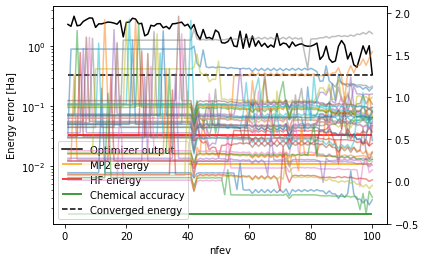

In [735]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(0.0016, 1, len(X), color='green', label='Chemical accuracy')

axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

axis_param = axis.twinx()
for Y_param in list(zip(*interim_values['params']))[1:]:
    axis_param.plot(X, Y_param, alpha=0.5)

axis.legend()
plt.show()

In [649]:
molecule.fci_energy

-98.6033017772588

array([0.0564031 , 0.94766316, 0.27928377, 0.5610533 , 0.36793529,
       0.04368217, 0.64563269, 0.43199477, 0.7121987 , 0.61344371,
       0.14291015, 0.40405992, 0.16513253, 0.99694731, 0.55262941,
       0.11565353, 0.39763441, 0.29420458, 0.86971234, 0.64499898,
       0.13146913, 0.4635723 , 0.23947577, 0.23214158])

In [227]:
"""A sample runtime program that submits random circuits for user-specified iterations."""

import random

from qiskit import transpile
from qiskit.circuit.random import random_circuit


def prepare_circuits(backend):
    """Generate a random circuit.

    Args:
        backend: Backend used for transpilation.

    Returns:
        Generated circuit.
    """
    circuit = random_circuit(
        num_qubits=5, depth=4, measure=True, seed=random.randint(0, 1000)
    )
    return transpile(circuit, backend)


def main(backend, user_messenger, **kwargs):
    """Main entry point of the program.

    Args:
        backend: Backend to submit the circuits to.
        user_messenger: Used to communicate with the program consumer.
        kwargs: User inputs.
    """
    iterations = kwargs.pop("iterations", 5)
    for it in range(iterations):
        qc = prepare_circuits(backend)
        result = backend.run(qc).result()
        user_messenger.publish({"iteration": it, "counts": result.get_counts()})

    return "Hello, World!"

In [228]:
import sys
import json

sys.path.insert(0, "..")  # Add source_program directory to the path
from qiskit import Aer
from qiskit.providers.ibmq.runtime import UserMessenger
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder

inputs = {"iterations": 3}

backend = Aer.get_backend("qasm_simulator")
user_messenger = UserMessenger()
serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

main(backend, user_messenger, **deserialized_inputs)

{"iteration": 0, "counts": {"00100": 12, "00000": 14, "01100": 492, "01000": 506}}
{"iteration": 1, "counts": {"00001": 430, "00111": 594}}
{"iteration": 2, "counts": {"00100": 5, "10001": 527, "00001": 147, "10101": 160, "00101": 43, "10100": 26, "10000": 88, "00000": 28}}


'Hello, World!'

In [685]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister, assemble

qr = QuantumRegister(n_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_fitter.cal_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [693]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [696]:
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

noise_model = get_noise(0.1)

t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_fitter.cal_matrix

array([[0.7332, 0.0795, 0.0813, 0.0093, 0.078 , 0.0097, 0.0085, 0.001 ],
       [0.0771, 0.7363, 0.0096, 0.0814, 0.0087, 0.0782, 0.0011, 0.0095],
       [0.0792, 0.0093, 0.7278, 0.085 , 0.0088, 0.0008, 0.0783, 0.0098],
       [0.0089, 0.0803, 0.0769, 0.7232, 0.0009, 0.0086, 0.0108, 0.0823],
       [0.0814, 0.0087, 0.008 , 0.0007, 0.7271, 0.0798, 0.0781, 0.0094],
       [0.0105, 0.0756, 0.0009, 0.0081, 0.0857, 0.7314, 0.0102, 0.0773],
       [0.0078, 0.0014, 0.0844, 0.0096, 0.0816, 0.0081, 0.732 , 0.0788],
       [0.0019, 0.0089, 0.0111, 0.0827, 0.0092, 0.0834, 0.081 , 0.7319]])